# Who Are You People!?!

A project to analyze the face of user(s) and output the most similar face from a database of well-known figures.

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os.path
from os import path

import shutil
#import os, shutil

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

# Where is the data from?

The data was downloaded from the website of two age and gender detectors called "IMDB-WIKI – 500k+ face images with age and gender labels" (Rasmus Rothe, Radu Timofte, Luc Van Gool - ETH Zürich’s Computer Vision Lab)

The images were webcrawled from the IMDB profiles of celebrities and Wikipedia pages of articles of people by popularity (visits) at some point before February 2016 (when the images were created).


## What does the data look like?

All files are downloadable as .tar archives. There is a wiki_data folder and imdb_data folder that contain subfolders of images and a .mat file of metadata.

The authors used matlab for all of their coding and storage of their text metadata. I converted the metadata to python myself, which is essentially decompressing/flattenting the arrays and dictionaries that appear when the .mat files are read in by scipy. I saved my conversion work as pandas DataFrames in csv format.

You have the ability to download the full images in batches or the cropped images of the faces.
    - Stored in subfolders numbered 0-99
    - File types of the images are .jpg


## The Main DataFrames:

In [2]:
#Load the converted metadata files for the IMDB and Wikipedia images
imdb = pd.read_csv('photo_metadata.csv')
wiki = pd.read_csv('wiki_photo_metadata.csv')

#Concat the two pandas DataFrames
photo_df = pd.concat([imdb, wiki]).reset_index(drop=True)

## The metadata mainframe information


### Given:
-**name:** Name of the person

-**dob:** date of birth (Matlab serial date number)

-**gender:** 0 for female and 1 for male, NaN if unknown

-**photo_taken:** year when the photo was taken

-**full_path:** path to file

-**face_location:** location of the face. To crop the face in Matlab run img(face_location(2):face_location(4),face_location(1):face_location(3),:))

-**face_score:** detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image

**Not Seen In This Notebook:**

-**second_face_score:** detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.**Not Seen In This Notebook**

-**celeb_names (IMDB only):** list of all celebrity names

-**celeb_id (IMDB only):** index of celebrity name


### Created:

-**age_when_taken** birthdate subtracted from photo_taken

In [3]:
photo_df.head()

,name,dob,gender,photo_taken,age_when_taken,file_path,face_location,face_score
0,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm124825600_...,[1072.926 161.838 1214.784 303.696],1.459693
1,Fred Astaire,1899-05-10,1.0,1970,71,image_data/imdb_data/01/nm0000001_rm3343756032...,[477.184 100.352 622.592 245.76 ],2.543198
2,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm577153792_...,[114.96964309 114.96964309 451.68657236 451.68...,3.455579
3,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm946909184_...,[622.88550564 424.21750384 844.33900767 645.67...,1.872117
4,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm980463616_...,[1013.85900236 233.88204221 1201.5861278 42...,1.158766


In [4]:
#There are 511817 total images across 73399 individuals
photo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384199 entries, 0 to 384198
Data columns (total 8 columns):
name              384199 non-null object
dob               384199 non-null object
gender            384199 non-null float64
photo_taken       384199 non-null int64
age_when_taken    384199 non-null int64
file_path         384199 non-null object
face_location     384199 non-null object
face_score        384199 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 23.4+ MB


In [5]:
photo_df.name.nunique()

55011

In [6]:
#A search for any name in the dataframe
photo_df[photo_df['name'].str.contains("veronica", case=False)]

,name,dob,gender,photo_taken,age_when_taken,file_path,face_location,face_score
71145,Veronica Cartwright,1949-04-20,0.0,2014,65,image_data/imdb_data/21/nm0001021_rm1483078912...,[627.65082516 233.75275006 834.13710021 440.23...,3.442111
71146,Veronica Cartwright,1949-04-20,0.0,1979,30,image_data/imdb_data/21/nm0001021_rm1514047232...,[ 896.05400813 523.55150474 1117.50751016 74...,1.398652
71147,Veronica Cartwright,1949-04-20,0.0,1986,37,image_data/imdb_data/21/nm0001021_rm1697943040...,[265.53183388 792.49950163 432.86629851 959.83...,1.252984
71148,Veronica Cartwright,1949-04-20,0.0,2009,60,image_data/imdb_data/21/nm0001021_rm2784923136...,[ 77.16663444 178.91948037 305.25853778 407.01...,1.823152
71149,Veronica Cartwright,1949-04-20,0.0,1998,49,image_data/imdb_data/21/nm0001021_rm2853362688...,[1116.16 542.72 1261.568 688.128],1.311692
71150,Veronica Cartwright,1949-04-20,0.0,2009,60,image_data/imdb_data/21/nm0001021_rm4190800128...,[253.18935896 135.43285811 328.03596665 210.27...,1.972485
71151,Veronica Cartwright,1949-04-20,0.0,1983,34,image_data/imdb_data/21/nm0001021_rm595689728_...,[ 936.67485249 153.98306901 1130.55479836 34...,4.650794
137579,Veronica Webb,1965-02-23,0.0,2010,45,image_data/imdb_data/42/nm0005542_rm1101891072...,[ 83.69987522 111.39583362 207.71968804 235.41...,4.071560
137580,Veronica Webb,1965-02-23,0.0,1997,32,image_data/imdb_data/42/nm0005542_rm1218549760...,[ 4.99772598 67.65788969 44.7572598 107.41...,2.783639
137581,Veronica Webb,1965-02-23,0.0,1996,31,image_data/imdb_data/42/nm0005542_rm2311493632...,[193.5465525 81.19039687 264.83950969 152.48...,4.115015


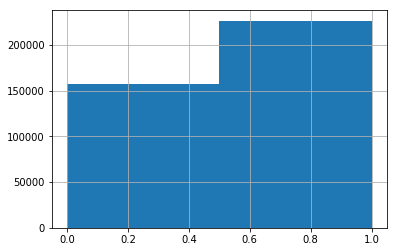

In [7]:
#gender histogram
photo_df.gender.hist(bins = 2)

In [8]:
#A check to see if the file path exists
file_exists = 0
file_not_exist = 0

for i in tqdm_notebook(photo_df.file_path, 
                         desc="Processing records"):
    if path.exists(i):
        file_exists += 1
    else: 
        file_not_exist += 1
        
print(file_exists)
print(file_not_exist)


384199
0


# The Images

## Fred Astaire <img style='width:300px' src='imdb_data/01/nm0000001_rm124825600_1899-5-10_1968.jpg'/> 

## Fred Astaire In Costume 
<img style='width:300px' src='imdb_data/01/nm0000001_rm3343756032_1899-5-10_1970.jpg'/> 

## Fred Astaire In a Tuxedo 
<img style='width:300px' src='imdb_data/01/nm0000001_rm577153792_1899-5-10_1968.jpg'/> 

## Not Fred Astaire
<img style='width:300px' src='imdb_data/01/nm0000001_rm980463616_1899-5-10_1968.jpg'/> 

## Fred Astaire and Barbara Hancock in Finian's Rainbow (1968)

<img style='width:300px' src='fred_image/fred_full.jpg'/> 

The face with the highest **face_score** is the default face for a given person.

The three options for dealing with this are:
    
   (1) Manually label each face
        
   (2) Drop all images where multiple faces were detected (298,367 images left)
        
   (3) Create a threshold metric where there is a minimum percent difference between the first face score and the second face score (What the paper suggests)
        
   -Worked for Lauren Bacall but not for Fred Astaire:
            
   -Fred Astaire's Picture His face wasn't detected, most likely because of the obscured eyes
                
   -Lauren Bacall's Pictures Group photos were dropped because the faces had similar scores.

    
This is where the second_face_score comes in handy

# What's Next?

The following is a broad overview of my tasks over the next 6 - 8 days:

**Step 1: Build the model**
**Step 2: Train the model**
**Step 3: Create A User interface for inputting images**
**Step 4: Implement A Live Feed For Demonstration **

-**Positives**
  -I reviewed the basics of neural Networks, and can follow the math behind simple forward/backward propagation

-**Negatives**
  -I am not sure where to go from here.
  
      (A) I have a few chapters on face detection and recognition, however they go into using specific pretrained models and I don't want to simply import someone's model
      
      (B) There are online tutorials/projects however I don't want to copy them straight out and just train them on my dataset
      
      (C) Learn goes over CNNs for simple classifications, I don't believe my desired task is necessarily a classification task because I am outputting most similar face from a dataset of 70k+ people.
      
      -We all can no longer afford to waste time focusing on the fundamentals of general topics
      
**This is where I am stuck and appreciate your input**
  
  